# 1. Import Libraries

In [ ]:
# import system libs
import os

# from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# import Deep learning Libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report

# import required EfficientNet50 components
from tensorflow.keras.applications import EfficientNetB0

import warnings
warnings.filterwarnings("ignore")

# 2. Helper Functions


In [ ]:
def train_and_evaluate_model(model, train_gen, valid_gen, test_gen, augmentation_type, epochs=50):
    """
    Train model and visualize results for a specific augmentation strategy
    """
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        verbose=1
    )

    # plot and get metrics
    metrics = plot_training_history(history, augmentation_type)

    # get precision and recall
    predicted_classes, true_classes = get_predictions(model, test_gen)
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    metrics.update({
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1
    })

    return history, metrics


In [ ]:
def plot_training_history(history, augmentation_type):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch = {str(index_loss + 1)}'
    acc_label = f'best epoch = {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title(f'{augmentation_type} Augmentation - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title(f'{augmentation_type} Augmentation - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    metrics = {
        'best_val_loss': val_lowest,
        'best_val_loss_epoch': index_loss + 1,
        'best_val_acc': acc_highest,
        'best_val_acc_epoch': index_acc + 1
    }

    return metrics


In [ ]:
def get_predictions(model, generator):
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes
    return predicted_classes, true_classes

def evaluate_model(model, generator, class_names):
    predicted_classes, true_classes = get_predictions(model, generator)

    # get detailed metrics
    precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes)

    # print classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    return precision, recall, f1, support

In [ ]:
def confusion_matrix_plot(test_gen, y_predict):
  y_pred = np.argmax(y_predict, axis=1)

  # get class indices and labels
  class_indices = test_gen.class_indices
  classes = list(class_indices.keys())

  # compute confusion matrix
  cm = confusion_matrix(test_gen.classes, y_pred)

  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  threshold = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(
          j, i, f"{cm[i, j]}",
          horizontalalignment='center',
          color='white' if cm[i, j] > threshold else 'black'
      )

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

# 3. Load Data

## 3.1 Loading from Kaggle

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_lung_and_colon_cancer_histopathological_images_path = kagglehub.dataset_download('andrewmvd/lung-and-colon-cancer-histopathological-images')

print('Data source import complete.')


100%|██████████| 1.76G/1.76G [00:20<00:00, 92.9MB/s]

Extracting files...


Data source import complete.


In [ ]:
print(andrewmvd_lung_and_colon_cancer_histopathological_images_path)

/root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1


In [ ]:
print(os.listdir(andrewmvd_lung_and_colon_cancer_histopathological_images_path))

['lung_colon_image_set']


## 3.2 Joining Images

In [ ]:
data_dir = '/root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/lung_colon_image_set'

file_paths = []
labels = []

folders = os.listdir(data_dir)

for folder in folders:
    sub_folder_path = os.path.join(data_dir, folder)
    sub_folder = os.listdir(sub_folder_path)

    for sfolder in sub_folder:
        s_sub_folder_path = os.path.join(sub_folder_path, sfolder)
        file_list = os.listdir(s_sub_folder_path)

        for file in file_list:
            fpath = os.path.join(s_sub_folder_path, file)

            file_paths.append(fpath)
            labels.append(sfolder)


FSeries = pd.Series(file_paths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

df = pd.concat([FSeries, LSeries], axis=1)

## 3.3 Split Data

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['labels'])

valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels'])

# 4. Preprocessing

## 4.1 Helper Function

In [ ]:
# Function to create data generators for each augmentation pipeline
def create_data_generators(train_df, valid_df, test_df, augmentation_pipeline):
    train_generator = augmentation_pipeline.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    # Validation and test generators use only rescaling
    valid_test_generator = ImageDataGenerator(rescale=1./255)

    valid_generator = valid_test_generator.flow_from_dataframe(
        dataframe=valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = valid_test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, valid_generator, test_generator

## 4.2 Data Augmentation

In [ ]:
# Define image size and batch size
IMG_SIZE = 224  # Standard size for many CNN architectures
BATCH_SIZE = 32

### 4.2.1 Basic Augmentation

In [ ]:
# Basic Augmentation Pipeline
# Focuses on basic geometric transformations
basic_augmentation = ImageDataGenerator(
    rescale=1./255
)

# Create generators for each augmentation pipeline
basic_train_gen, basic_valid_gen, basic_test_gen = create_data_generators(
    train_df, valid_df, test_df, basic_augmentation)

Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


### 4.2.2 Moderate Augmentation

In [ ]:
# Moderate Augmentation Pipeline
# Adds intensity transformations while preserving tissue characteristics
moderate_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

moderate_train_gen, moderate_valid_gen, moderate_test_gen = create_data_generators(
    train_df, valid_df, test_df, moderate_augmentation)


Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


### 4.2.3 Advanced Augmentation

In [ ]:
# Advanced Augmentation Pipeline
# Includes color transformations suitable for histopathology
advanced_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True
)

advanced_train_gen, advanced_valid_gen, advanced_test_gen = create_data_generators(
    train_df, valid_df, test_df, advanced_augmentation
)

Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


# 5. Model Initialization

 ## 5.1 EfficientNetB0 Model


In [ ]:
def create_model():
  img_size = (224, 224)
  channels = 3
  img_shape = (img_size[0], img_size[1], channels)
  class_count = len(list(basic_train_gen.class_indices.keys()))

  base_model = EfficientNetB0(include_top=False, input_shape=img_shape)

  x = base_model.input
  x = base_model(x, training=True)
  x = GlobalAveragePooling2D()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  output = Dense(class_count, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=output)

  model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
  model.summary()

  return model

## 5.2 Model Training

### 5.2.1 Training Basic Augmentation

In [ ]:
model_basic = create_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 4,172,161 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 227s 272ms/step - accuracy: 0.9346 - loss: 0.1902 - val_accuracy: 0.3800 - val_loss: 3.3193
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 111s 203ms/step - accuracy: 0.9923 - loss: 0.0204 - val_accuracy: 0.2032 - val_loss: 3789.9333
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 107s 196ms/step - accuracy: 0.9970 - loss: 0.0109 - val_accuracy: 0.2821 - val_loss: 2.1539
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 110s 200ms/step - accuracy: 0.9972 - loss: 0.0095 - val_accuracy: 0.4424 - val_loss: 3.7212
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 106s 193ms/step - accuracy: 0.9984 - loss: 0.0055 - val_accuracy: 0.5328 - val_loss: 3.0565
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 109s 199ms/step - accuracy: 0.9990 - loss: 0.0031 - val_accuracy: 0.2971 - val_loss: 4.1550
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 106s 194ms/step - accuracy: 0.9981 - loss: 0.0050 - val_accuracy: 0.3808 - val_loss: 4.0335
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 106s 194ms/step - accuracy: 0.998

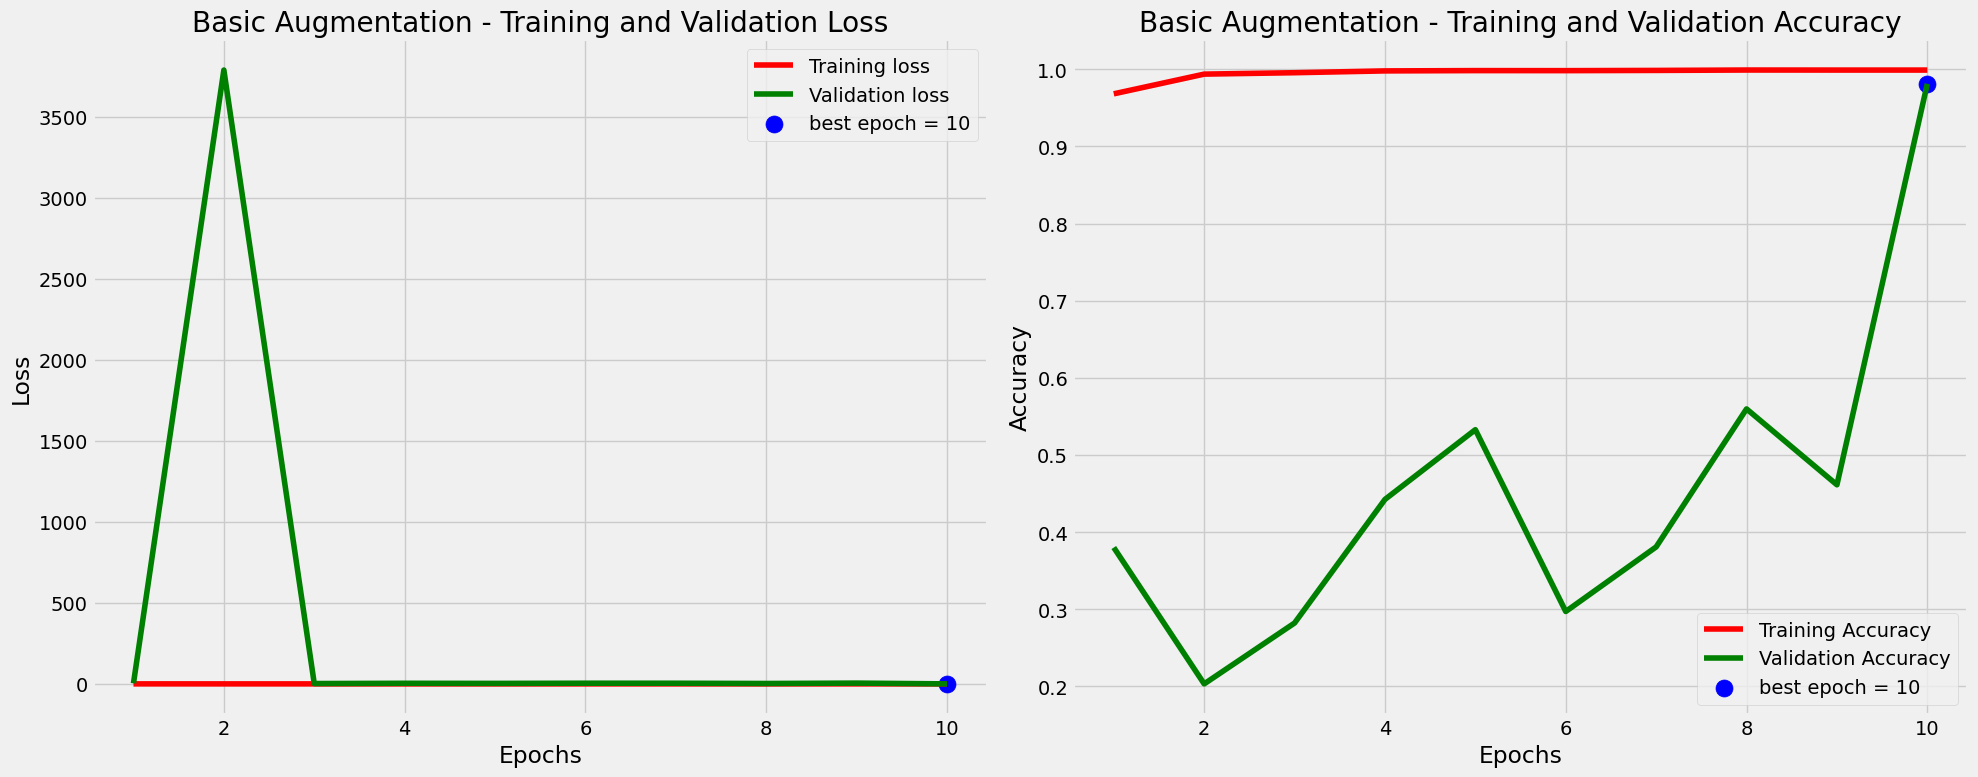

118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 190ms/step


In [ ]:
hist_basic, metrics_basic = train_and_evaluate_model(model_basic, basic_train_gen, basic_valid_gen, basic_test_gen, 'Basic', epochs=10)

118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step


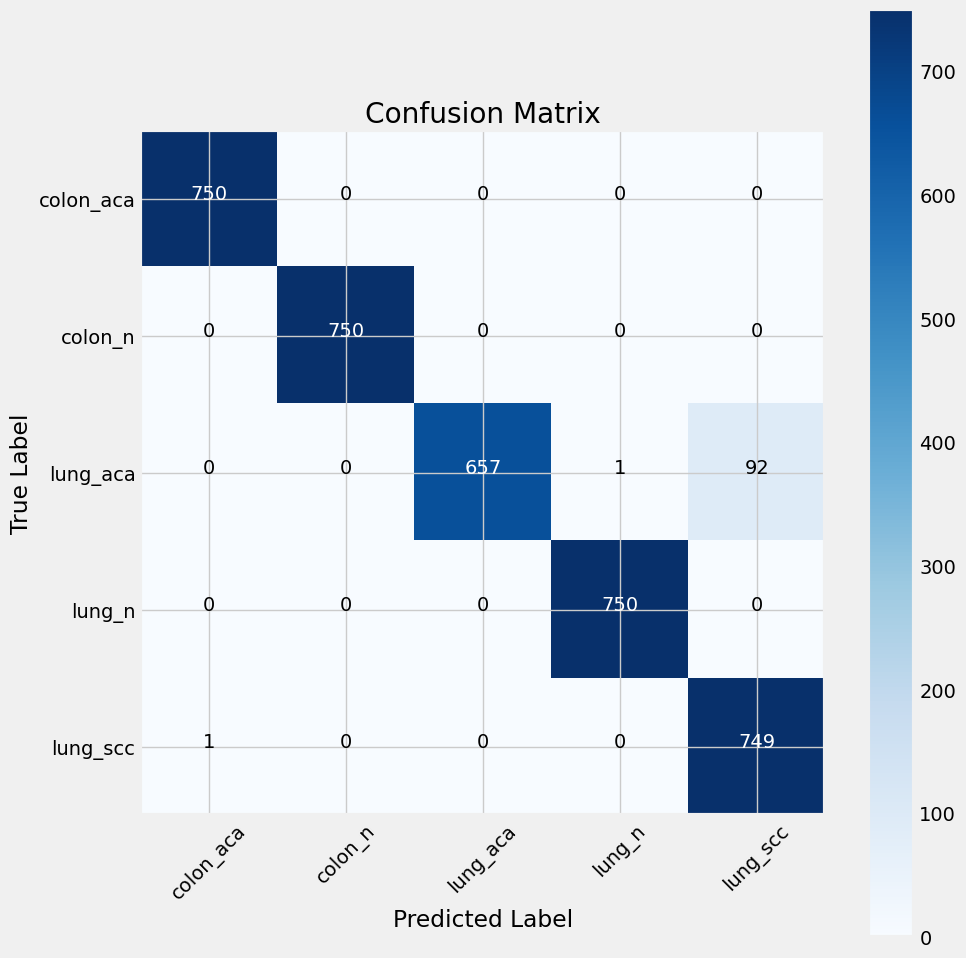

In [ ]:
y_predict_basic = model_basic.predict(basic_test_gen)
confusion_matrix_plot(basic_test_gen, y_predict_basic)

### 5.2.2 Training Moderate Augmentation

In [ ]:
model_moderate = create_model()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 4,172,161 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 386s 575ms/step - accuracy: 0.9282 - loss: 0.2087 - val_accuracy: 0.4760 - val_loss: 1.7647
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 272s 497ms/step - accuracy: 0.9913 - loss: 0.0261 - val_accuracy: 0.2411 - val_loss: 2.7536
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 277s 505ms/step - accuracy: 0.9946 - loss: 0.0160 - val_accuracy: 0.1776 - val_loss: 20.8209
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 274s 500ms/step - accuracy: 0.9979 - loss: 0.0083 - val_accuracy: 0.2037 - val_loss: 3.9579
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 275s 502ms/step - accuracy: 0.9973 - loss: 0.0078 - val_accuracy: 0.3405 - val_loss: 3.1472
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 271s 495ms/step - accuracy: 0.9982 - loss: 0.0065 - val_accuracy: 0.3304 - val_loss: 1.8759
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 323s 497ms/step - accuracy: 0.9973 - loss: 0.0057 - val_accuracy: 0.2672 - val_loss: 5.2164
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 275s 502ms/step - accuracy: 0.9985 

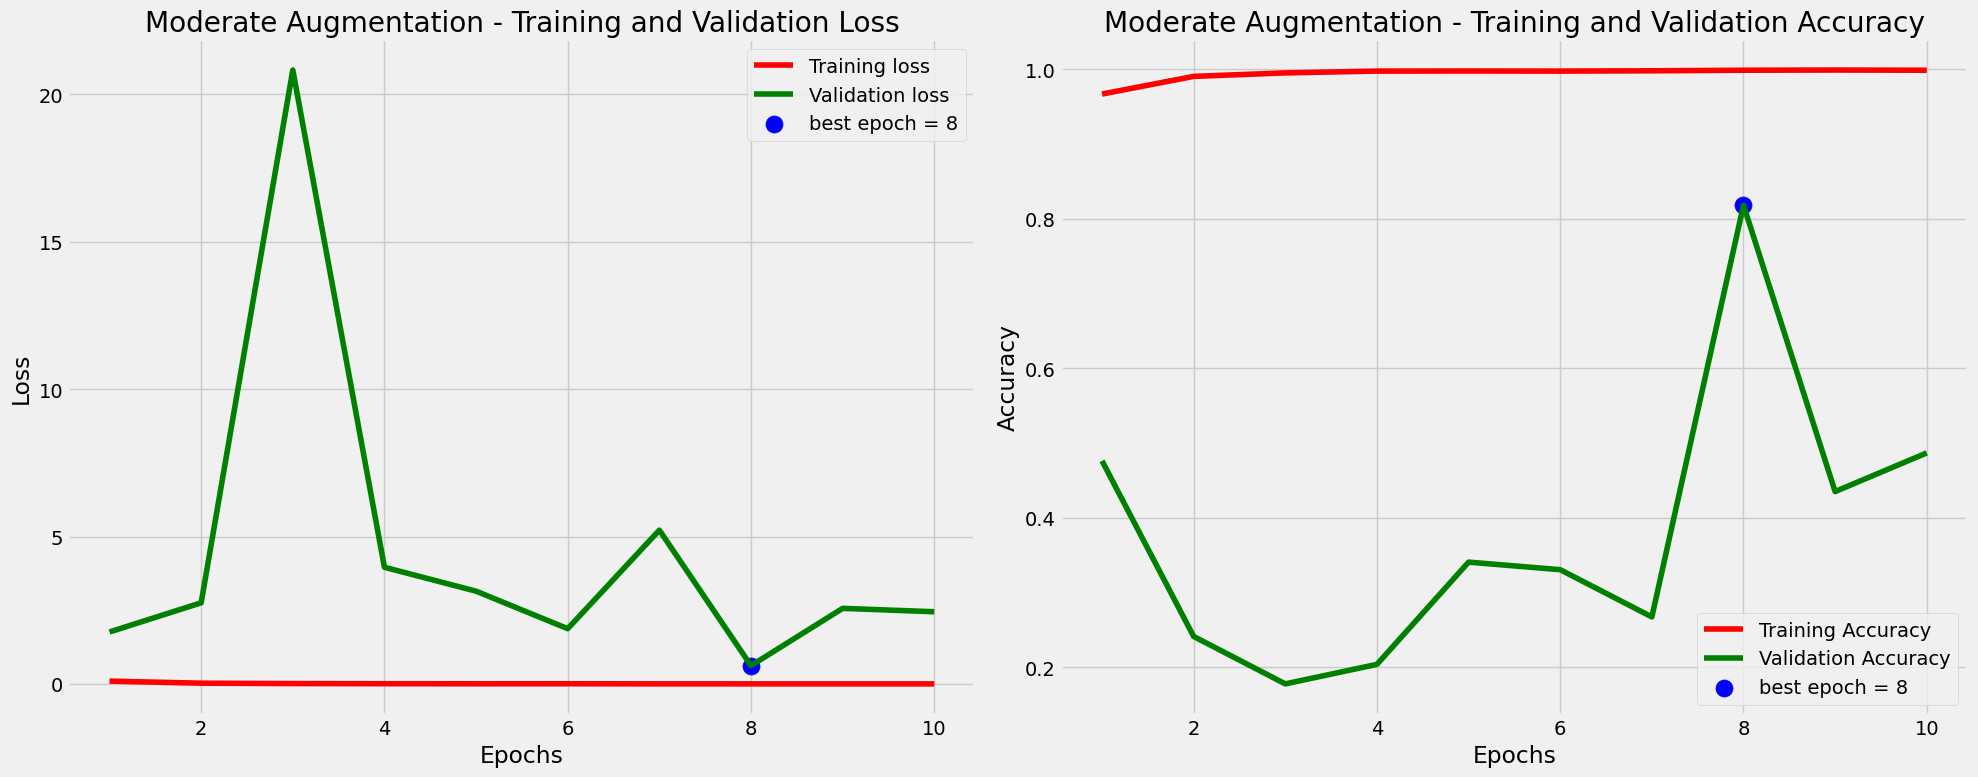

118/118 ━━━━━━━━━━━━━━━━━━━━ 28s 187ms/step


In [ ]:
hist_moderate, metrics_moderate = train_and_evaluate_model(model_moderate, moderate_train_gen, moderate_valid_gen, moderate_test_gen, "Moderate", epochs= 10)

118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step


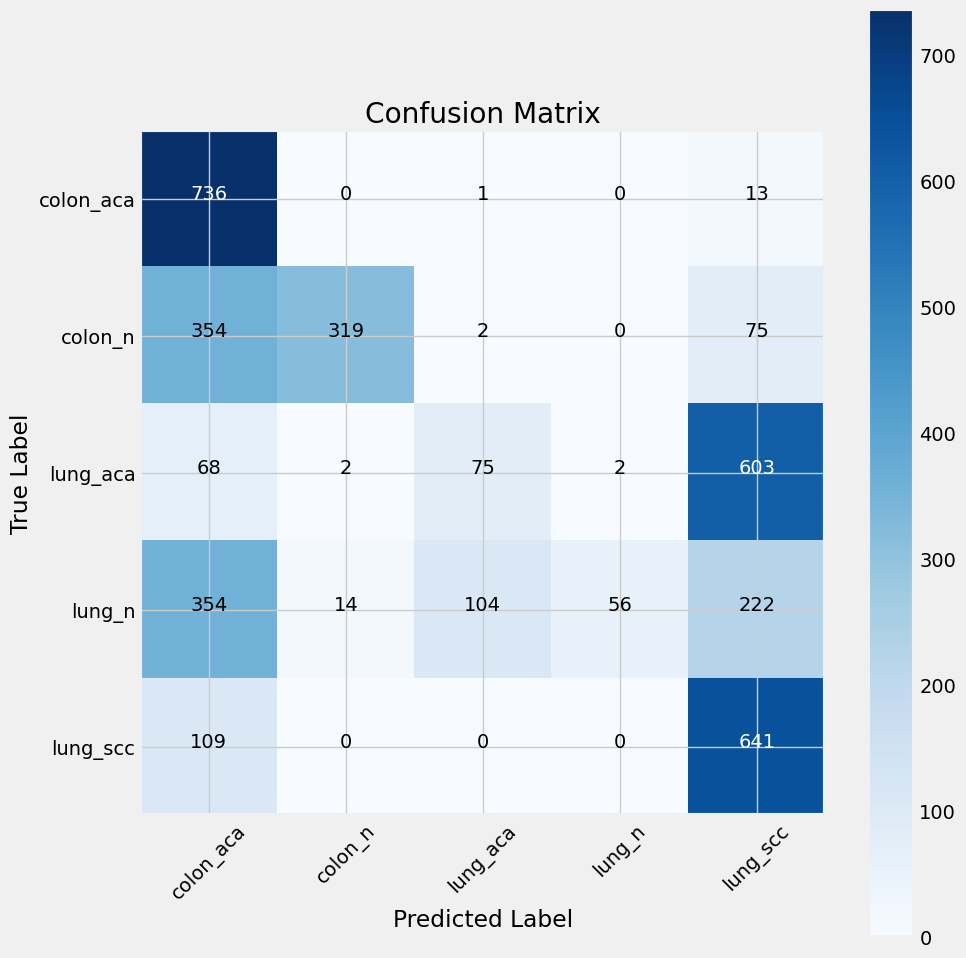

In [ ]:
y_predict_moderate = model_moderate.predict(moderate_test_gen)
confusion_matrix_plot(moderate_test_gen, y_predict_moderate)

### 5.2.3 Training Advanced Augmentation

In [ ]:
model_advanced = create_model()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 4,172,161 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 412s 613ms/step - accuracy: 0.9331 - loss: 0.1940 - val_accuracy: 0.2005 - val_loss: 6.6380
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 273s 499ms/step - accuracy: 0.9888 - loss: 0.0328 - val_accuracy: 0.6637 - val_loss: 1.7736
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 279s 510ms/step - accuracy: 0.9949 - loss: 0.0143 - val_accuracy: 0.3629 - val_loss: 2.8720
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 268s 490ms/step - accuracy: 0.9960 - loss: 0.0114 - val_accuracy: 0.2195 - val_loss: 5.7863
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 272s 497ms/step - accuracy: 0.9983 - loss: 0.0054 - val_accuracy: 0.2000 - val_loss: 8.7312
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 271s 495ms/step - accuracy: 0.9980 - loss: 0.0061 - val_accuracy: 0.3475 - val_loss: 2.8685
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 276s 504ms/step - accuracy: 0.9986 - loss: 0.0058 - val_accuracy: 0.3816 - val_loss: 1.8111
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 279s 509ms/step - accuracy: 0.9987 -

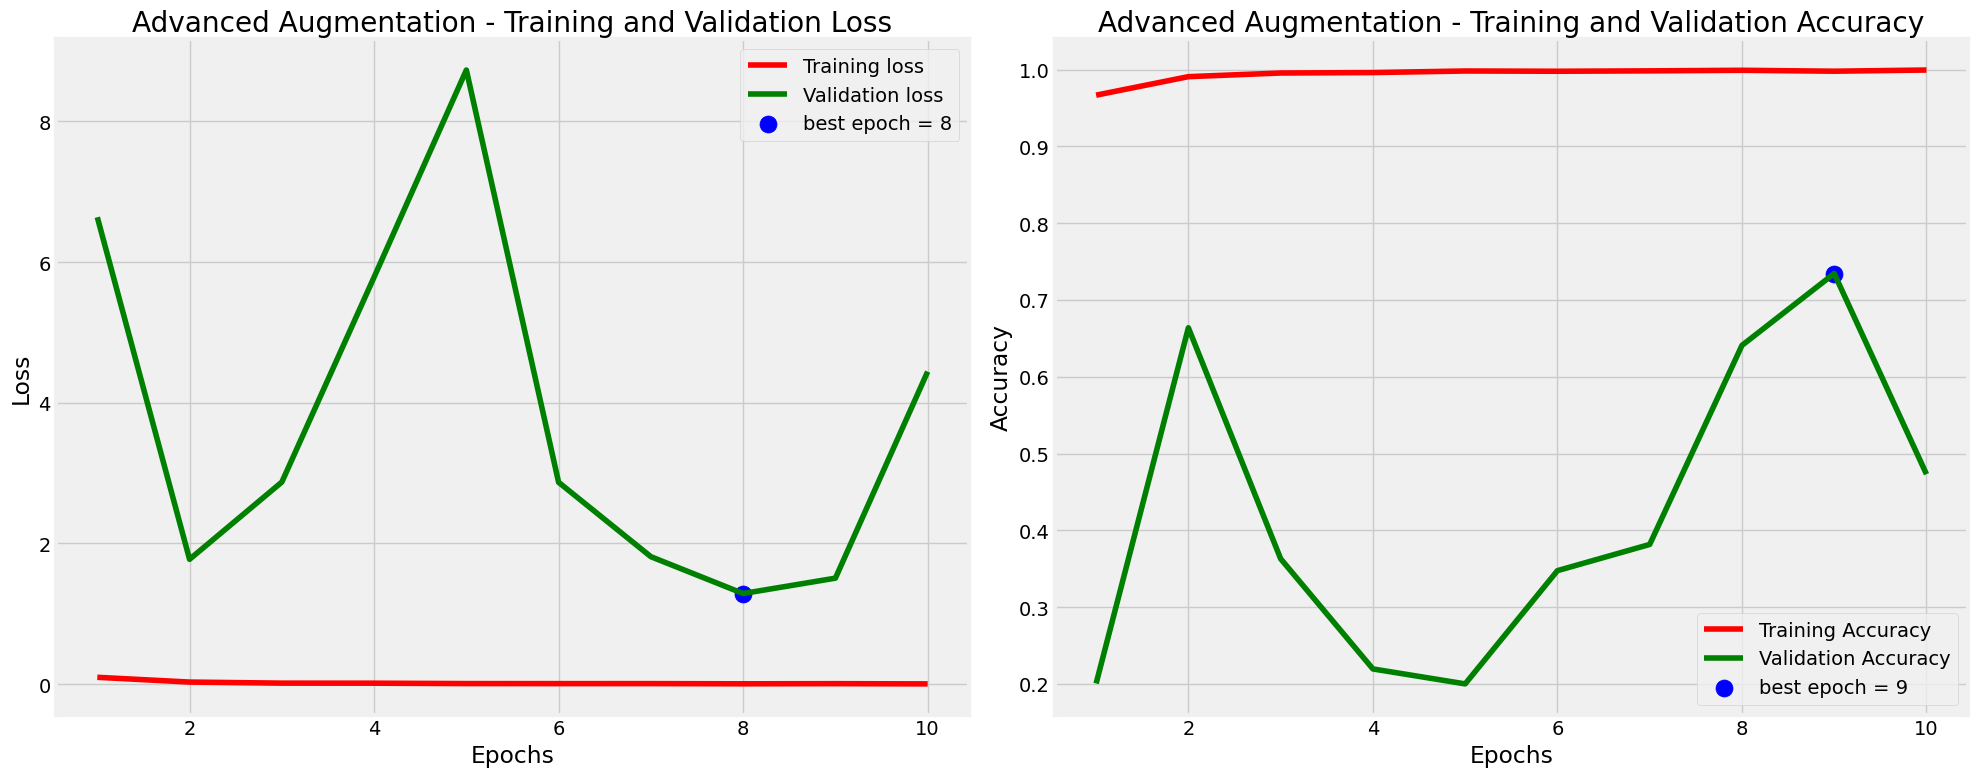

118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 190ms/step


In [ ]:
hist_advanced, metrics_advanced = train_and_evaluate_model(model_advanced, advanced_train_gen, advanced_valid_gen, advanced_test_gen, "Advanced", epochs=10)

118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step


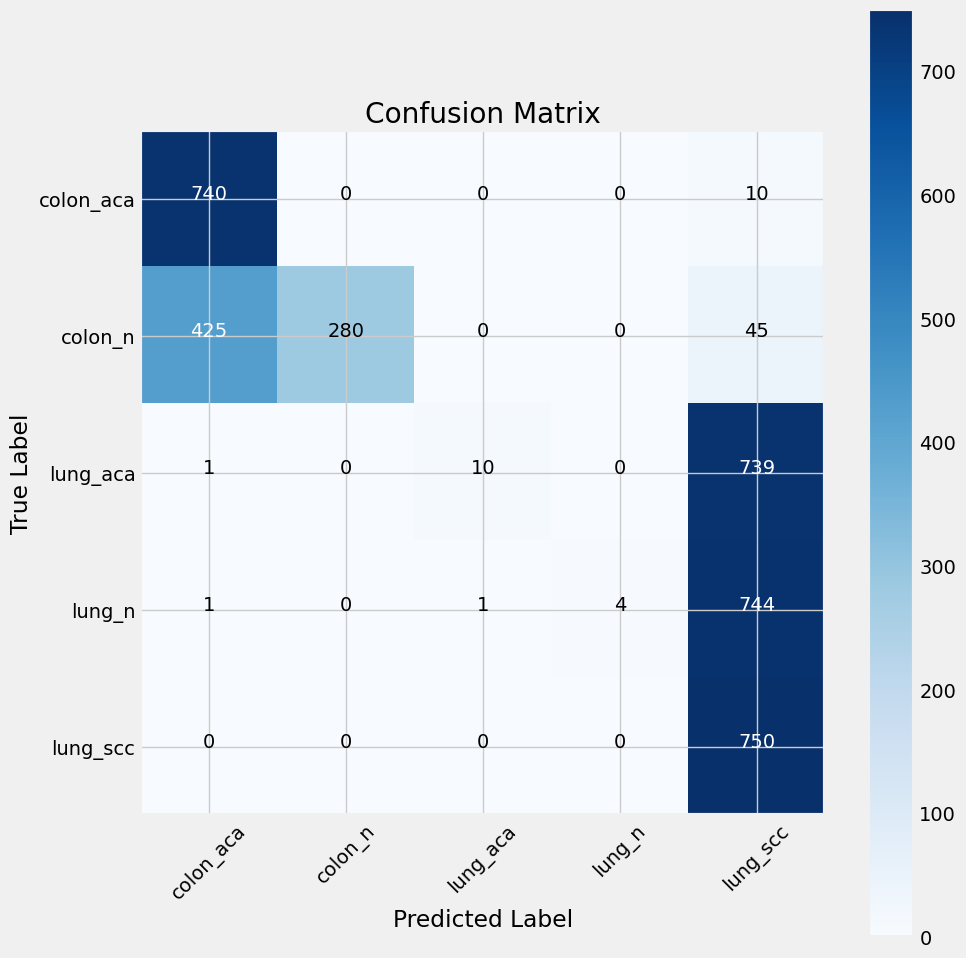

In [ ]:
y_predict_advanced = model_advanced.predict(advanced_test_gen)
confusion_matrix_plot(advanced_test_gen, y_predict_advanced)

# 6. Evaluation

In [ ]:
print(metrics_basic)

{'best_val_loss': 0.08465283364057541, 'best_val_loss_epoch': 10, 'best_val_acc': 0.981333315372467, 'best_val_acc_epoch': 10, 'test_precision': 0.9775886610163856, 'test_recall': 0.9749333333333333, 'test_f1': 0.974823134260011}


In [ ]:
print(metrics_moderate)

{'best_val_loss': 0.6220942139625549, 'best_val_loss_epoch': 8, 'best_val_acc': 0.8181333541870117, 'best_val_acc_epoch': 8, 'test_precision': 0.6392737175057868, 'test_recall': 0.4872, 'test_f1': 0.4129670404729191}


In [ ]:
print(metrics_advanced)

{'best_val_loss': 1.2872674465179443, 'best_val_loss_epoch': 8, 'best_val_acc': 0.7343999743461609, 'best_val_acc_epoch': 9, 'test_precision': 0.7741985306895333, 'test_recall': 0.47573333333333334, 'test_f1': 0.36927322792591877}
